## Please run this notebook in google colab

## Import packages, setup google bigquery environment and query the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd //content/drive/MyDrive/cse6250

/content/drive/MyDrive/cse6250


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math, os
import seaborn as sns

In [ ]:
!pip install seaborn --upgrade

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table
# GCP proejct
project_id = 'nlp-332020'
project_number = '1054321893028'

%env GCLOUD_PROJECT=project_id
# authenticate colab notebook
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client(project=project_id)

Authenticated
env: GCLOUD_PROJECT=project_id


In [ ]:
comb = client.query('''
with adm as 
(SELECT
SUBJECT_ID, HADM_ID, FIRST_ADMITTIME, ADMITTIME, DISCHTIME, DEATHTIME, ADMISSION_TYPE,
      # GENDER,AGE,EXPIRE_FLAG
  DURATION,
 case when NEXT_ADMITTIME is null then lead(NEXT_ADMITTIME) over (partition by SUBJECT_ID order by ADMITTIME) 
  else NEXT_ADMITTIME end as NEXT_ADMITTIME,
 case when NEXT_ADMISSION_TYPE  is null then lead(NEXT_ADMISSION_TYPE) over (partition by SUBJECT_ID order by ADMITTIME) 
  else NEXT_ADMISSION_TYPE  end as NEXT_ADMISSION_TYPE 
  from 
  (SELECT 
  SUBJECT_ID, HADM_ID, FIRST_ADMITTIME,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,
      # GENDER,AGE,EXPIRE_FLAG
  DURATION,
--   NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
   case when NEXT_ADMISSION_TYPE = 'ELECTIVE' then null  
  else NEXT_ADMISSION_TYPE end as NEXT_ADMISSION_TYPE,
 case when NEXT_ADMISSION_TYPE = 'ELECTIVE' then null  
  else NEXT_ADMITTIME end as NEXT_ADMITTIME
  FROM (
      SELECT  
    SUBJECT_ID, HADM_ID, FIRST_ADMITTIME,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,
      # GENDER,AGE,EXPIRE_FLAG
    lead(ADMITTIME) over (partition by SUBJECT_ID order by ADMITTIME) as NEXT_ADMITTIME,
    lead(admission_type) over (partition by SUBJECT_ID order by ADMITTIME) as NEXT_ADMISSION_TYPE,
    DATE_DIFF(dischtime, Admittime, DAY)  as DURATION

  FROM
  (select distinct 
    SUBJECT_ID, HADM_ID,FIRST_ADMITTIME,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,
      # GENDER,AGE,EXPIRE_FLAG
    from 
    `nlp-332020.readmission_dataset.cleaned_dataset`) a
    ) b
  ) c 
  WHERE admission_type!='NEWBORN' AND deathtime is null 
  ),
    notes as (
        SELECT
   SUBJECT_ID, HADM_ID, CHARTDATE, TEXT
   FROM
   (
  SELECT
   SUBJECT_ID, HADM_ID, CHARTDATE, TEXT,  
   row_number() over (partition by SUBJECT_ID, HADM_ID order by CHARTDATE DESC) as rk
  FROM
  (SELECT DISTINCT 
   SUBJECT_ID, HADM_ID,  CHARTDATE, TEXT
   FROM 
    `nlp-332020.readmission_dataset.cleaned_dataset`
    -- WHERE SUBJECT_ID IN (9, 13, 18)
  ) tmp
) tmp1
WHERE rk=1
    )

    select adm.SUBJECT_ID, adm.HADM_ID,
    #  GENDER,AGE,
    FIRST_ADMITTIME,ADMITTIME,DISCHTIME,DEATHTIME,
    ADMISSION_TYPE,
    # EXPIRE_FLAG,
  DURATION,
   NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,
  DATE_DIFF( NEXT_ADMITTIME, DISCHTIME, DAY) as DAYS_NEXT_ADMIT,
  case when DATE_DIFF( NEXT_ADMITTIME, DISCHTIME, DAY)<30 then 1 else 0 end as OUTPUT_LABEL,
  TEXT
   
FROM adm
LEFT JOIN notes
on adm.SUBJECT_ID = notes.SUBJECT_ID
AND adm.HADM_ID = notes.HADM_ID
where TEXT is not null
''').to_dataframe()

In [ ]:
print(comb.shape)

In [ ]:
raw = pd.read_csv('all.csv') ## the large mimic file saved in google drive, which includes patient, icu stay, admission and event notes
raw.columns

Index(['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG', 'hadm_id', 'icustay_id', 'intime', 'outtime', 'LOS',
       'CHARTDATE', 'TEXT', 'age', 'first_admittime', 'Admittime', 'dischtime',
       'deathtime', 'admission_type', 'insurance', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data', 'preiculos',
       'hospital_expire_flag_1', 'ICUSTAY_AGE_GROUP', 'ICUSTAY_EXPIRE_FLAG'],
      dtype='object')

In [ ]:
col = [i.upper() for i in raw.columns]
raw.columns = col

In [ ]:
raw.columns

Index(['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG', 'HADM_ID', 'ICUSTAY_ID', 'INTIME', 'OUTTIME', 'LOS',
       'CHARTDATE', 'TEXT', 'AGE', 'FIRST_ADMITTIME', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'PREICULOS',
       'HOSPITAL_EXPIRE_FLAG_1', 'ICUSTAY_AGE_GROUP', 'ICUSTAY_EXPIRE_FLAG'],
      dtype='object')

In [ ]:
raw['ADMISSION_TYPE'].value_counts(normalize=True)

EMERGENCY    0.774559
ELECTIVE     0.132581
NEWBORN      0.064875
URGENT       0.027984
Name: ADMISSION_TYPE, dtype: float64

In [ ]:
raw['SUBJECT_ID'].nunique(), raw['HADM_ID'].nunique()

(41074, 51940)

In [ ]:
raw['TEXT'].nunique()

58600

In [ ]:
raw.groupby(['HOSPITAL_EXPIRE_FLAG'])['SUBJECT_ID','HADM_ID'].nunique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,SUBJECT_ID,HADM_ID
HOSPITAL_EXPIRE_FLAG,,
0,37084,46682
1,5257,5258


## Create binary target variable and explore its distribution

In [ ]:
# comb = pd.read_csv('comb.csv')
# comb.columns

Index(['SUBJECT_ID', 'HADM_ID', 'FIRST_ADMITTIME', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'DURATION', 'NEXT_ADMITTIME',
       'NEXT_ADMISSION_TYPE', 'DAYS_NEXT_ADMIT', 'OUTPUT_LABEL', 'TEXT'],
      dtype='object')

In [ ]:
comb.DAYS_NEXT_ADMIT.describe()

count    10085.000000
mean       408.666634
std        633.748609
min        -19.000000
25%         26.000000
50%        124.000000
75%        507.000000
max       4108.000000
Name: DAYS_NEXT_ADMIT, dtype: float64

In [ ]:
comb['OUTPUT_LABEL_60'] = comb['DAYS_NEXT_ADMIT'].apply(lambda r: 1 if r<60 else 0)
comb['OUTPUT_LABEL_90'] = comb['DAYS_NEXT_ADMIT'].apply(lambda r: 1 if r<90 else 0)
comb['OUTPUT_LABEL_120'] = comb['DAYS_NEXT_ADMIT'].apply(lambda r: 1 if r<120 else 0)
comb['OUTPUT_LABEL_180'] = comb['DAYS_NEXT_ADMIT'].apply(lambda r: 1 if r<180 else 0)

In [ ]:
comb['SUBJECT_ID'].nunique(), comb['HADM_ID'].nunique()

(33593, 43100)

In [ ]:
comb['OUTPUT_LABEL'].value_counts(), comb['OUTPUT_LABEL_180'].value_counts()

(0    40379
 1     2721
 Name: OUTPUT_LABEL, dtype: int64, 0    37400
 1     5700
 Name: OUTPUT_LABEL_180, dtype: int64)

In [ ]:
x = comb[['OUTPUT_LABEL', 'OUTPUT_LABEL_180']]
x.rename(columns={'OUTPUT_LABEL':'Re-admit within 30days', 'OUTPUT_LABEL_180':'Re-admit within 6months'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
x1 = x.apply(lambda x: x.value_counts()).T.stack().reset_index()
x1.columns=['Target', 'Readmission_label', 'Count']
x1['Readmission_label'] = x1['Readmission_label'].astype('str')

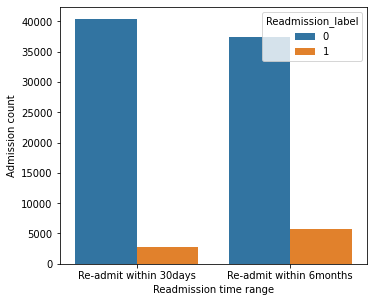

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
ax=sns.barplot(x='Target', y='Count', hue='Readmission_label', data=x1) 
ax.set_xlabel('Readmission time range')
ax.set_ylabel('Admission count')
# ax.legend()
plt.tight_layout(pad=0.001)
# plt.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left', borderaxespad=0, title = 'Readmission_label')
# plt.annotate('Admission count', xy=(x+0.2,y), xytext=(x+0.3, 300) )

fig.savefig("label dist.png", dpi=1200)

## Check ADMISSION_TYPE distribution

In [ ]:
comb['ADMISSION_TYPE'].value_counts(), comb['NEXT_ADMISSION_TYPE'].value_counts()

(EMERGENCY    35260
 ELECTIVE      6715
 URGENT        1125
 Name: ADMISSION_TYPE, dtype: int64, EMERGENCY    9941
 URGENT        144
 Name: NEXT_ADMISSION_TYPE, dtype: int64)

In [ ]:
comb.groupby(['ADMISSION_TYPE', 'NEXT_ADMISSION_TYPE'])['HADM_ID'].nunique()

ADMISSION_TYPE  NEXT_ADMISSION_TYPE
ELECTIVE        EMERGENCY               956
                URGENT                   27
EMERGENCY       EMERGENCY              8767
                URGENT                   95
URGENT          EMERGENCY               218
                URGENT                   22
Name: HADM_ID, dtype: int64

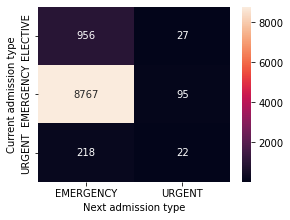

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
# ax.set_title("Fig1: Consecutive Admission Distribution")
ax = sns.heatmap(pd.crosstab(comb['ADMISSION_TYPE'], comb['NEXT_ADMISSION_TYPE']), annot=True, fmt='d');
ax.set_ylabel('Current admission type')
ax.set_xlabel('Next admission type')
plt.yticks(rotation=90)
plt.tight_layout(0.5)
fig.savefig("consecutive_admission_dist1.png", dpi=1200)

## Check note and its length distribution

In [ ]:
comb['note_len'] = comb['TEXT'].apply(lambda r: len(r))
comb['note_len'].describe()

count    43100.000000
mean     10534.514084
std       5566.894438
min         54.000000
25%       6805.000000
50%       9851.000000
75%      13513.000000
max      53330.000000
Name: note_len, dtype: float64

In [ ]:
comb.groupby(['OUTPUT_LABEL']).agg({'note_len': ['min', 'max', 'mean']}).reset_index()

OUTPUT_LABEL note_len                     
                    min    max          mean
0            0       54  53330  10417.138067
1            1      612  53169  12276.346564

In [ ]:
notecnt = raw.groupby(['SUBJECT_ID', 'HADM_ID'])['TEXT'].size().reset_index(name='notecnt')
notecnt.notecnt.describe()

count    51940.000000
mean         1.217058
std          0.678615
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         42.000000
Name: notecnt, dtype: float64

In [ ]:
len(notecnt[notecnt.notecnt>1])/len(raw)

0.1300503053121144

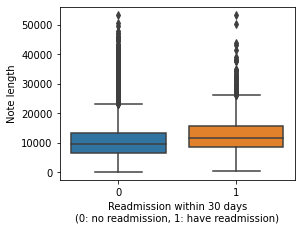

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
# ax.set_title("Fig2: Note Length vs. Readmission within 30 days")
ax = sns.boxplot(x='OUTPUT_LABEL', y='note_len', data = comb)
ax.set_xlabel('Readmission within 30 days\n(0: no readmission, 1: have readmission)')
ax.set_ylabel('Note length')
plt.tight_layout(0.0001)
# ax.legend(['0: no readmission', '1: have readmission'], bbox_to_anchor=(0.09, -0.02))
fig.savefig("notelength_dist.png", dpi=1200)

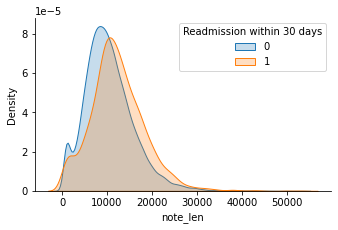

In [ ]:
g=sns.FacetGrid(comb, hue='OUTPUT_LABEL', height=3, aspect=1.5)
g.map(sns.kdeplot, 'note_len', shade=True)
ax.set_xlabel('Note length')
plt.legend(loc='upper right', title='Readmission within 30 days')
plt.tight_layout(0.0001)
# plt.savefig("age_dist.png", dpi=1200)

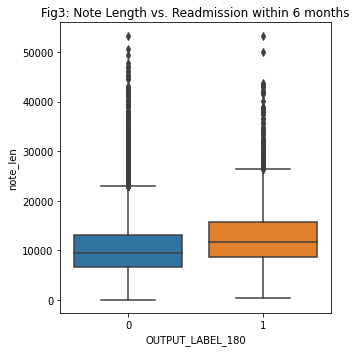

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_title("Fig3: Note Length vs. Readmission within 6 months")
ax = sns.boxplot(x='OUTPUT_LABEL_180', y='note_len', data = comb)
plt.tight_layout()
fig.savefig("notelength_dist180.png", dpi=600)

## Merge with demo data and check age and gender distribution btw different target group

In [ ]:
## get age, gender, los, 'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS'
demo = raw[['SUBJECT_ID', 'HADM_ID','AGE','GENDER', 'LOS','MARITAL_STATUS', 'ETHNICITY','ICUSTAY_AGE_GROUP', 'ICUSTAY_EXPIRE_FLAG']].drop_duplicates()
print(demo.shape)
demo.head()

(55588, 9)


,SUBJECT_ID,HADM_ID,AGE,GENDER,LOS,MARITAL_STATUS,ETHNICITY,ICUSTAY_AGE_GROUP,ICUSTAY_EXPIRE_FLAG
0,624,120063,78,F,1.6020,MARRIED,WHITE,adult,N
1,697,162458,26,M,2.2348,SINGLE,WHITE,adult,N
2,948,107027,29,F,2.5069,MARRIED,WHITE,adult,N
3,948,142734,29,F,1.2674,MARRIED,WHITE,adult,N
4,948,125857,39,F,1.1646,MARRIED,WHITE,adult,N


In [ ]:
demo_comb = pd.merge(comb, demo, on=['SUBJECT_ID','HADM_ID'], how = 'left')
demo_comb.shape

(45932, 25)

In [ ]:
demo_comb.rename(columns={'OUTPUT_LABEL':'Readmission within 30 days'}, inplace = True)

In [ ]:
len(demo_comb[demo_comb['AGE']<200])/len(demo_comb)

0.9540407559000261

In [ ]:
demo_comb['AGE'].describe()

count    45932.000000
mean        72.838479
std         52.634400
min          0.000000
25%         52.000000
50%         65.000000
75%         77.000000
max        311.000000
Name: AGE, dtype: float64

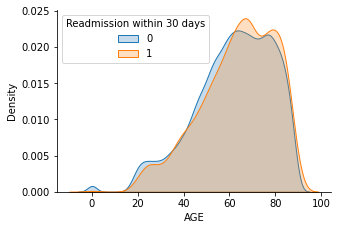

In [ ]:
demo1 = demo_comb[demo_comb['AGE']<200] # remove age outliers
g=sns.FacetGrid(demo1, hue='Readmission within 30 days', height=3, aspect=1.5)
g.map(sns.kdeplot, 'AGE', shade=True)
plt.legend(loc='upper left', title='Readmission within 30 days')
plt.tight_layout(0.0001)
plt.savefig("age_dist.png", dpi=1200)

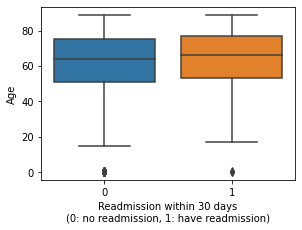

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
# ax.set_title("Fig2: Age vs. Readmission within 30 days")
ax = sns.boxplot(x='OUTPUT_LABEL', y='AGE', data = demo_comb[demo_comb['AGE']<200])
ax.set_xlabel('Readmission within 30 days\n(0: no readmission, 1: have readmission)')
ax.set_ylabel('Age')
plt.tight_layout(0.0001)
fig.savefig("age_dist.png", dpi=1200)

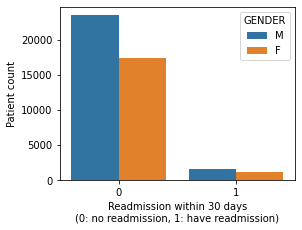

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
# ax.set_title("Fig2: Age vs. Readmission within 30 days")
ax = sns.countplot(x='Readmission within 30 days', hue='GENDER', data = demo1)
ax.set_xlabel('Readmission within 30 days\n(0: no readmission, 1: have readmission)')
ax.set_ylabel('Patient count')
plt.tight_layout(0.0001)
fig.savefig("gender_dist.png", dpi=1200)